**Engy-5050** Reactor Physics, UMass Lowell, Chem. Eng. Nuclear Program Spring 2022; Prof. V. F. de Almeida

# 1-D Point Source Neutron Transport
$  
  \newcommand{\Amtrx}{\boldsymbol{\mathsf{A}}}
  \newcommand{\Bmtrx}{\boldsymbol{\mathsf{B}}}
  \newcommand{\Mmtrx}{\boldsymbol{\mathsf{M}}}
  \newcommand{\Imtrx}{\boldsymbol{\mathsf{I}}}
  \newcommand{\Pmtrx}{\boldsymbol{\mathsf{P}}}
  \newcommand{\Lmtrx}{\boldsymbol{\mathsf{L}}}
  \newcommand{\Umtrx}{\boldsymbol{\mathsf{U}}}
  \newcommand{\Smtrx}{\boldsymbol{\mathsf{S}}}
  \newcommand{\xvec}{\boldsymbol{\mathsf{x}}}
  \newcommand{\uvar}{\boldsymbol{u}}
  \newcommand{\fvar}{\boldsymbol{f}}
  \newcommand{\avec}{\boldsymbol{\mathsf{a}}}
  \newcommand{\bvec}{\boldsymbol{\mathsf{b}}}
  \newcommand{\cvec}{\boldsymbol{\mathsf{c}}}
  \newcommand{\rvec}{\boldsymbol{\mathsf{r}}}
  \newcommand{\mvec}{\boldsymbol{\mathsf{m}}}
  \newcommand{\gvec}{\boldsymbol{\mathsf{g}}}
  \newcommand{\zerovec}{\boldsymbol{\mathsf{0}}}
  \newcommand{\norm}[1]{\bigl\lVert{#1}\bigr\rVert}
  \newcommand{\transpose}[1]{{#1}^\top}
  \DeclareMathOperator{\rank}{rank}
  \newcommand{\Power}{\mathcal{P}}
$

**Student(s):** Anthony Bowers, Andrew Hamel <br>
**Course:** Engy-5050 Reactor Physics  <br>


UMass Lowell, Dept. of Chemical Engineering, Nuclear Energy Program 
<br>
**7March2022**

---
## Table of Contents<a id="toc"></a>
* [Introduction](#intro)
* [Problem Statement](#problem)
* [Objectives](#obj)
* [Approach](#app)
 + [Analytical Solution](#analyticalsol)
 + [Weak Form of Problem Statement](#weakform)
 + [MOOSE Kernels](#kernels)
 + [Setup](#setup)
    - [One-Group Energy](#onegroupenergy)
* [Results and Analysis](#ranalysis)
* [Conclusions](#conclusions)
* [References](#refs)
---

### Domain
The domain utilized in the simulation is spherical geometry containt a point source. Surronding the point source is light-water.

In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

## [Simulation](#toc)<a id="ranalysis"></a>

In [14]:
!rm output1G*.csv
!./neutron__transport-opt -i input-test.hit



Framework Information:
MOOSE Version:           git commit b98ea2c450 on 2021-09-23
LibMesh Version:         
PETSc Version:           3.15.1
SLEPc Version:           3.15.1
Current Time:            Wed Mar  9 19:34:26 2022
Executable Timestamp:    Tue Mar  8 13:20:10 2022

Parallelism:
  Num Processors:          1
  Num Threads:             1

Mesh: 
  Parallel Type:           replicated
  Mesh Dimension:          1
  Spatial Dimension:       1
  Nodes:                   20001
  Elems:                   10000
  Num Subdomains:          1

Nonlinear System:
  Num DOFs:                60003
  Num Local DOFs:          60003
  Variables:               { "u1" "u2" "u3" } 
  Finite Element Types:    "LAGRANGE" 
  Approximation Orders:    "SECOND" 

Execution Information:
  Executioner:             Steady
  Solver Mode:             NEWTON
  PETSc Preconditioner:    lu 
  MOOSE Preconditioner:    FDP



*** Warning ***
/home/andrew/projects/neutron__transport/input-test.hit:10: unused parame

In [15]:
import pandas as pd
df = pd.read_csv('output1G_x-data_0002.csv')
#plot_solution(df, title='Dirichlet BC FEM Solution', basis_functions_type='Linear Lagrange', flux_basis_functions_type='Constant Monomial')
#print(df)


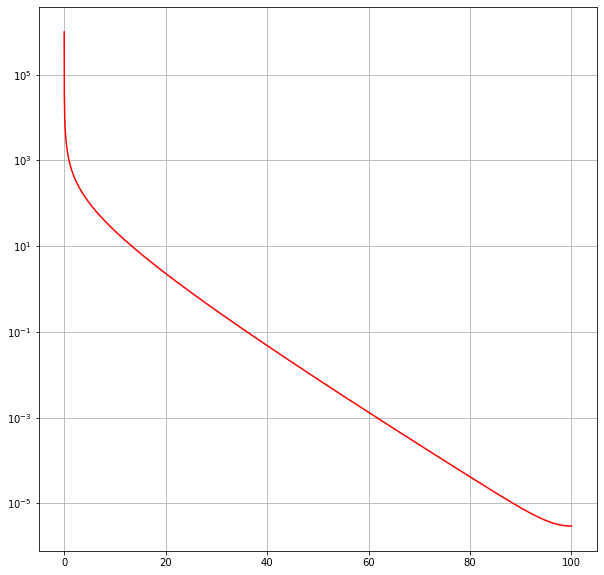

In [16]:
fig = plt.figure(figsize=(10,10))
plt.plot(df["x"],df["u1"],"r-")
plt.yscale("log")
#plt.xlim(0,100)
plt.grid()
plt.show()

In [20]:
!rm output2G*.csv
!./neutron__transport-opt -i input2G.hit

rm: cannot remove 'output2G*.csv': No such file or directory

Framework Information:
MOOSE Version:           git commit b98ea2c450 on 2021-09-23
LibMesh Version:         
PETSc Version:           3.15.1
SLEPc Version:           3.15.1
Current Time:            Wed Mar  9 19:35:17 2022
Executable Timestamp:    Tue Mar  8 13:20:10 2022

Parallelism:
  Num Processors:          1
  Num Threads:             1

Mesh: 
  Parallel Type:           replicated
  Mesh Dimension:          1
  Spatial Dimension:       1
  Nodes:                   20001
  Elems:                   10000
  Num Subdomains:          1

Nonlinear System:
  Num DOFs:                40002
  Num Local DOFs:          40002
  Variables:               { "u1" "u2" } 
  Finite Element Types:    "LAGRANGE" 
  Approximation Orders:    "SECOND" 

Execution Information:
  Executioner:             Steady
  Solver Mode:             NEWTON
  PETSc Preconditioner:    lu 
  MOOSE Preconditioner:    FDP



*** Warning ***
/home/andrew/proj

In [21]:
import pandas as pd
df = pd.read_csv('output2G_x-data_0002.csv')


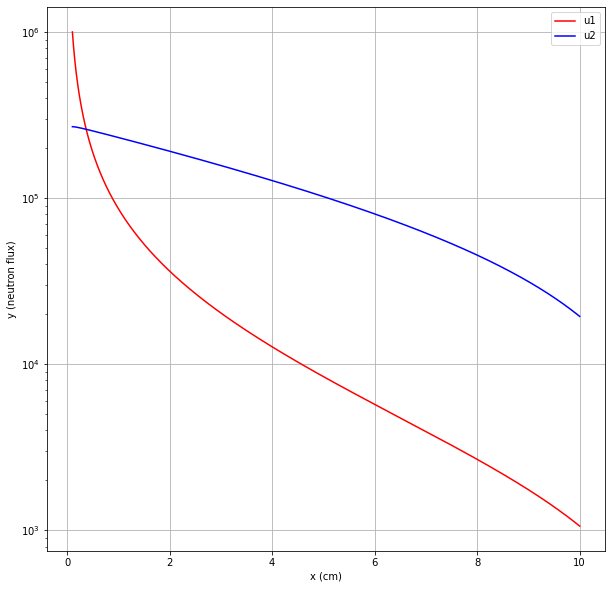

In [22]:
fig = plt.figure(figsize=(10,10))
plt.plot(df["x"],df["u1"],"r-",label="u1")
plt.plot(df["x"],df["u2"],"b-",label="u2")
plt.yscale("log")
#plt.xlim(0,100)
plt.grid()
plt.legend()
plt.xlabel("x (cm)")
plt.ylabel("y (neutron flux)")
plt.show()

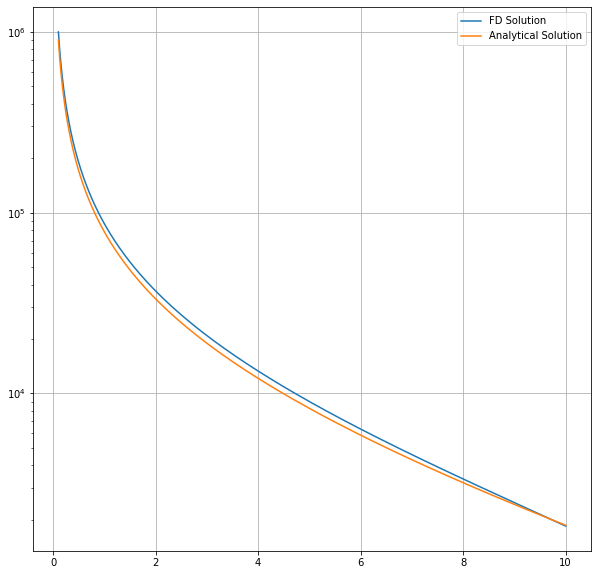

In [10]:
So = 1e6
N = 20000
rn = 10
r0 = 0.1
phi0 = So
alpha = 0.6

sigma_s = 0.022
D=0.87

h = (rn-r0)/(N+1)
r = np.arange(r0+h, rn, h)

A = np.zeros((N,N))
B = np.zeros(N)

A[0,0] = -sigma_s/D * h**2 - 2
A[0,1] = 1 + (h/(r0))
B[0] = -phi0 * (1-h/r0)

for i in range(1,N-1):
    A[i,i-1] = (1-(h/r[i]))
    A[i,i] = -sigma_s/D * h**2 - 2
    A[i,i+1] = 1 + (h/r[i])
    B[i] = 0

A[-1,-1] = (-h * alpha - 2 - h**2 * alpha/rn - sigma_s * h**2 / D)
A[-1,-2] = 1 + 1+h/rn-h/rn
B[-1] = 0
L = np.sqrt(D/sigma_s)

yi = np.linalg.solve(A , B)
yi = np.concatenate((np.array([phi0]),yi,np.array([yi[-1]])))

r = np.concatenate((np.array([r0]),r,np.array([rn])))


x = np.linspace(0.1,10,N)
y = So/(4*np.pi * x * D)*np.exp(-x/L)

fig = plt.figure(figsize=(10,10))
plt.plot(r,yi,label="FD Solution")
plt.plot(x,y,label="Analytical Solution")
plt.yscale("log")
plt.grid()
plt.legend()
plt.savefig("AnalyticalFDSolution.png",dpi=300)
plt.show()

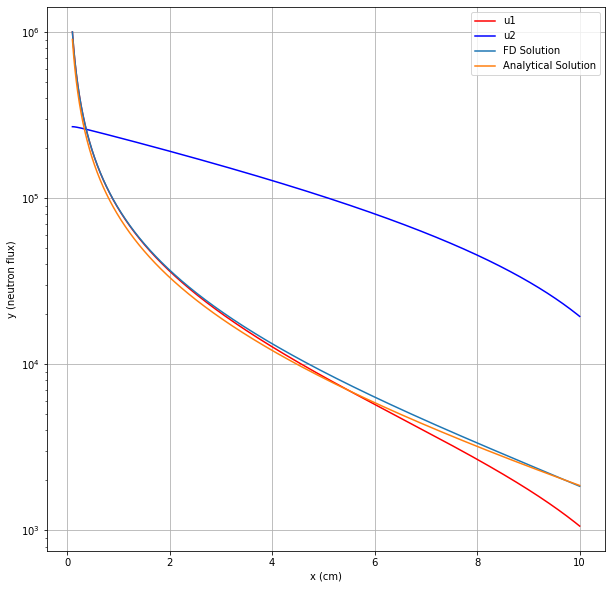

In [24]:
fig = plt.figure(figsize=(10,10))
plt.plot(df["x"],df["u1"],"r-",label="u1")
plt.plot(df["x"],df["u2"],"b-",label="u2")
plt.plot(r,yi,label="FD Solution")
plt.plot(x,y,label="Analytical Solution")
plt.yscale("log")
#plt.xlim(0,100)
plt.grid()
plt.legend()
plt.xlabel("x (cm)")
plt.ylabel("y (neutron flux)")
plt.show()

## [Results and Analysis](#toc)<a id="ranalysis"></a>